In [8]:
#data management imports
import numpy as np
import pandas as pd

#plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#modeling imports
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#sklearn shortcuts
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

#misc python packages
from IPython.display import clear_output
import time

In [9]:
#load trees data
trees = pd.read_csv('county_tree_temp_dwp_prcp_KT_NS10.csv')
trees = trees.sort_values(['state_code','county_code','species','year'])
trees = trees.reset_index(drop = True)

#clean data
trees = trees.drop(trees.loc[(trees.volume == 0) | (trees.height == 0)].index)

le = LabelEncoder()
trees['speciesID'] = le.fit_transform(trees.species)
trees['volume'] = trees['volume'] / trees['number_trees']
trees['Biomass'] = trees['Biomass'] / trees['number_trees']
trees['height'] = trees['height'] / trees['number_trees']
trees['diameter'] = trees['diameter'] / trees['number_trees']
trees['Density'] = trees['Biomass']/trees['volume']
trees['logMass'] = np.log(trees['Biomass'])
trees['logvolume'] = np.log(trees['volume'])
trees['logdensity'] = np.log(trees['Density'])
trees = trees.drop(trees.loc[trees.Density > 100].index)

species = trees.species.unique()

In [10]:
spe = ['loblolly pine','sweetgum','red maple','slash pine','yellow-poplar',
      'balsam fir','sugar maple','quaking aspen','northern white-cedar','paper birch']

#define features to be used
features = ['latitude','longitude','Density','mean_temp','height','logdensity',
            'Biomass','diameter','mean_prcp','mean_dwp','volume','logMass','logvolume']

trees10 = trees.loc[trees.species.isin(spe)].copy()

#split data
trees10 = trees.loc[trees.species.isin(spe)].copy() #top 10 trees
train,test = train_test_split(trees10,test_size=.1,shuffle=True,stratify = trees10.speciesID,random_state = 42)

t0 = time.perf_counter()
y = train.speciesID
X = train[features].copy()

In [11]:
gnb = Pipeline([('scaler',StandardScaler()),
                 ('GausNB',GaussianNB())])

In [12]:
pred = cross_val_predict(gnb,X,y, cv=4, n_jobs = -1)

In [13]:
pred_df = pd.DataFrame({'speciesID':y,'pred':pred,'correct': y == pred})
pred_df = pred_df.reset_index(drop = True)

precision = precision_score(y,pred, average = None)
recall = recall_score(y,pred, average = None)
matrix = confusion_matrix(y, pred)
accuracy = np.zeros(len(recall))
speID = le.transform(spe)
orderedspecies = le.inverse_transform(np.sort(speID))
final = pd.DataFrame({'accuracy':accuracy,
                      'recall':recall,
                      'precision':precision},
                     index = orderedspecies)
final.loc['Total'] = [accuracy_score(y,pred),
                      recall_score(y,pred, average = 'macro'),
                      precision_score(y,pred, average = 'macro')]
final

,accuracy,recall,precision
balsam fir,0.000000,0.878820,0.598278
loblolly pine,0.000000,0.598227,0.453478
northern white-cedar,0.000000,0.782357,0.658180
paper birch,0.000000,0.724609,0.317955
quaking aspen,0.000000,0.458480,0.715351
red maple,0.000000,0.339983,0.460689
slash pine,0.000000,0.597358,0.432182
sugar maple,0.000000,0.573349,0.747903
sweetgum,0.000000,0.439694,0.356721
yellow-poplar,0.000000,0.453810,0.594328


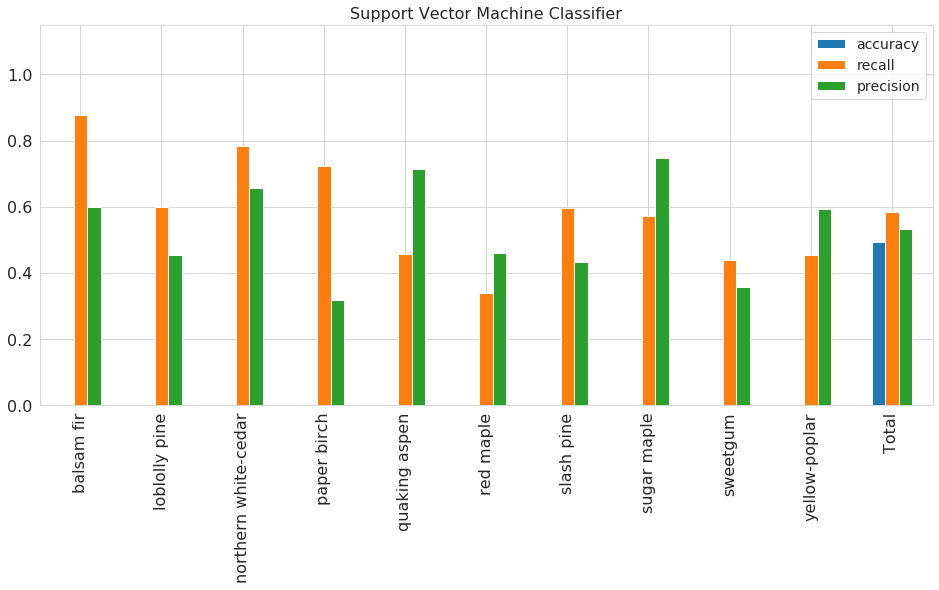

In [14]:
final.plot.bar(fontsize = 16,figsize = (16,7),legend = False)
plt.ylim((0,1.15))
plt.xlabel('',fontsize = 16)
plt.title('Support Vector Machine Classifier',fontsize = 16)
plt.legend(loc = 1,fontsize = 14)
plt.show()

### Grid Search Below to Find Optimal Parameters for the SVM

from sklearn.model_selection import cross_val_score

scores = []
C = []
coef = []

for coe in [0.1,1,10,100,1e3]:
    for c in [0.1,0.5,1,5,10]:
        clf2 = Pipeline([
            ("scaler",StandardScaler()),
            ("svm_clf",SVC(kernel = "poly", degree = 2, coef0 = coe, C=c))
        ])
        scores.append(cross_val_score(clf2,X, y, cv = 4, n_jobs = -1).mean())
        C.append(c)
        coef.append(coe)

best = np.argmax(scores)
plt.plot(scores)
print(f'C = {C[best]}, Coef0 = {coef[best]}, Score = {scores[best]}')

In [15]:
final.to_csv('GNBPred.csv')